
Goal right now:
1. write API for calling probes on layers
    done.
2. implement LEACE to 
3. test the utility of the algorithm, post LEACE and pre-LEACE, on each class.
    1. plot the new error - old error, for each class 


1. test that when you have better points for probes.
2. test that if you only run probe post layer `l`, where `l` is the layer that achieves above some probe accuracy
3. 

Using device: cuda
Generated data shape: torch.Size([500, 5])
Covariance matrix:
 tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.2500, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.1111, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0625, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0400]], device='cuda:0')


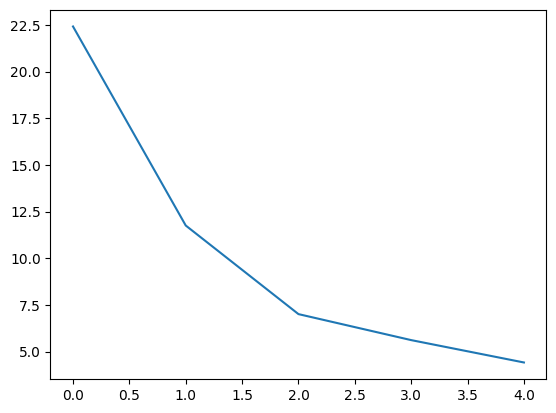

In [1]:
import torch
from importlib import reload 
from pathlib import Path 

from unlearning.datasets import gaussian 

BASE_DIR = Path("/n/home04/rrinberg/data_dir__sneel/Lab/rrinberg/results")




# Example usage:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

n_samples = 500

n_features = 5
alpha = 2  # Adjust alpha to change the rate of decay

# Generate the dataset and obtain the covariance matrix used
data, cov_matrix = gaussian.generate_powerlaw_gaussian_dataset(n_samples, n_features, alpha=alpha, device=device, mean = 2.)

print("Generated data shape:", data.shape)
print("Covariance matrix:\n", cov_matrix)

# Compute the empirical covariance matrix of the generated data for verification
data_centered = data - data.mean(dim=0, keepdim=True)
emp_cov = torch.mm(data_centered.t(), data_centered) / (n_samples - 1)

# Print the empirical covariance matrix
U, S, V = torch.svd(data_centered)
# plot S
import matplotlib.pyplot as plt
plt.plot(S.cpu().numpy())
plt.show()

Using device: cuda
X shape: torch.Size([1000, 2])
Covariance of the whitened data:
 tensor([[9.9999e-01, 4.3426e-06],
        [4.3426e-06, 9.9998e-01]], device='cuda:0')


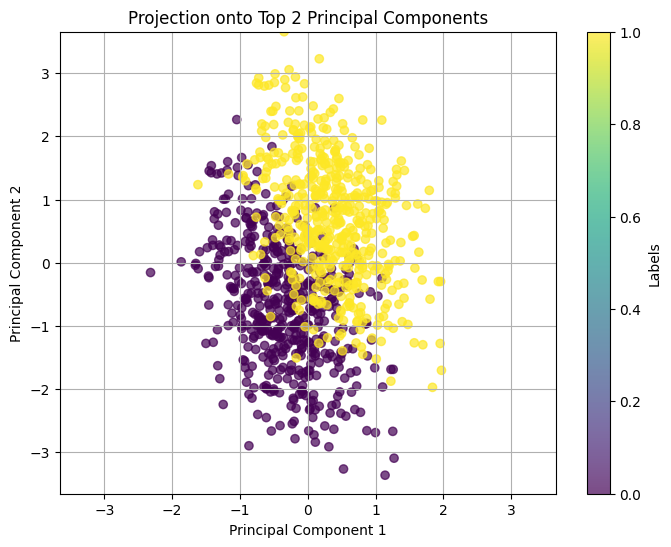

Variance of original data: tensor([1.3752, 0.5668], device='cuda:0')


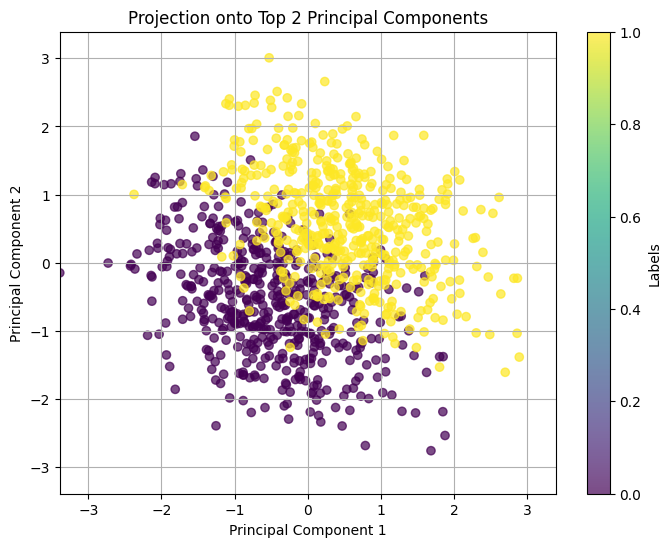

Covariance of whitened data: tensor([[1., 0.],
        [0., 1.]], device='cuda:0')
Variance of original data: tensor([1.0000, 1.0000], device='cuda:0')


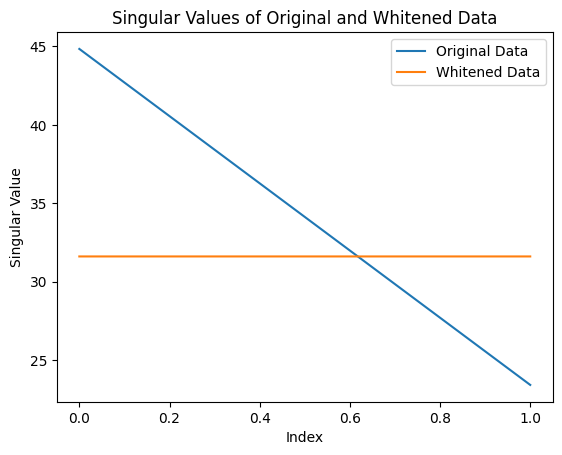

In [20]:
import torch
import matplotlib.pyplot as plt


from unlearning import probes
from unlearning import leace 

# Select device: use CUDA if available, otherwise CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

# Create a random dataset with 100 samples and 5 features on the selected device
torch.manual_seed(42)

n_samples = 500
n_features = 2
alpha = 2  # Adjust alpha to change the rate of decay
difference = 1.1

# Generate the dataset and obtain the covariance matrix used
X1, cov_matrix = gaussian.generate_powerlaw_gaussian_dataset(n_samples, n_features, alpha=alpha, device=device)
X2, cov_matrix = gaussian.generate_powerlaw_gaussian_dataset(n_samples, n_features, alpha=alpha, device=device, mean = difference)

data = torch.cat((X1, X2), dim=0)

labels = torch.zeros(len(data))
labels[len(X1):] = 1

print(f"X shape: {data.shape}")    
# Whiten the dataset
X_white = leace.whiten_data_torch(data)

# Verify that the covariance of the whitened data is approximately the identity matrix
n_samples = X_white.size(0)
cov_whitened = torch.mm(X_white.T, X_white) / (n_samples - 1)
print("Covariance of the whitened data:\n", cov_whitened)

# Optionally, generate some dummy labels (e.g., for binary classes)
#labels = torch.randint(0, 2, (n_samples,), device=device)

# plot original data with top pcs

probes.plot_top2_pcs_torch(data, labels=labels)
var_orig = torch.var(data, dim=0)
print(f"Variance of original data: {var_orig}")
# plot whitened data
probes.plot_top2_pcs_torch(X_white, labels=labels)
var_whitened = torch.var(X_white, dim=0)
covar_whitened = torch.cov(X_white.T)
# round covar_whitened to 2 decimal places
covar_whitened = torch.round(covar_whitened * 100) / 100
print(f"Covariance of whitened data: {covar_whitened}")
print(f"Variance of original data: {var_whitened}")

# plot the covariance matrix of the whitened data
U, S, V = torch.svd(data)
U_whitened, S_whitened, V_whitened = torch.svd(X_white)     
plt.plot(S.cpu().numpy(), label='Original Data')
plt.plot(S_whitened.cpu().numpy(), label='Whitened Data')
plt.xlabel('Index')
plt.ylabel('Singular Value')
plt.title('Singular Values of Original and Whitened Data')
plt.legend()
plt.show()


In [21]:
import torch
import torch.nn as nn
import torch.optim as optim

# Create a simple synthetic dataset
# We'll create two clusters in 2D space:
# - Cluster for class 0 centered at (-1, -1)
# - Cluster for class 1 centered at (1, 1)
torch.manual_seed(42)

dim = data.shape[1]

# Define the Logistic Regression model
class LogisticRegression(nn.Module):
    def __init__(self, input_dim):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(input_dim, 1)  # single output for binary classification

    def forward(self, x):
        # Apply linear transformation followed by a sigmoid activation
        x= x.float()
        return torch.sigmoid(self.linear(x))

# x to float
X = data.float()
labels = labels.float()
model = LogisticRegression(dim)
# model to device
model.to(device)
labels = labels.to(device)
X = X.to(device)
# Define the loss function and the optimizer
criterion = nn.BCELoss()  # Binary Cross Entropy Loss
optimizer = optim.SGD(model.parameters(), lr=0.1)

# Training loop
num_epochs = 1000
for epoch in range(num_epochs):
    # Forward pass: compute predicted y by passing X to the model
    outputs = model(X).squeeze()  # squeeze to remove extra dimensions
    loss = criterion(outputs, labels)
    
    # Zero gradients, perform backward pass, and update weights.
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Print loss every 100 epochs
    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

# Evaluate the trained model
with torch.no_grad():
    predictions = (model(X).squeeze() >= 0.5).float()  # threshold at 0.5 for binary classification
    accuracy = (predictions == labels).float().mean()
    print(f'Accuracy: {accuracy.item() * 100:.2f}%')


Epoch [100/1000], Loss: 0.3723
Epoch [200/1000], Loss: 0.3292
Epoch [300/1000], Loss: 0.3086
Epoch [400/1000], Loss: 0.2970
Epoch [500/1000], Loss: 0.2898
Epoch [600/1000], Loss: 0.2850
Epoch [700/1000], Loss: 0.2816
Epoch [800/1000], Loss: 0.2792
Epoch [900/1000], Loss: 0.2774
Epoch [1000/1000], Loss: 0.2761
Accuracy: 88.50%


In [22]:
# get layers of model
layers = list(model.children())
print(layers)
# get number of parameters in model
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Number of parameters in model: {num_params}')


[Linear(in_features=2, out_features=1, bias=True)]
Number of parameters in model: 3


In [48]:
# run linear probe from probes
from unlearning import probes
reload(probes)
#layer_ind = probes.get_layer_count(model) - layer_from_end
pos_points = X1
neg_points = X2
probe_acc, probe_model = probes.linear_probe(model=model, layer_ind = 0, pos_points=pos_points, neg_points=neg_points, device=device)
print(probe_acc)

Processing sample 0
Processing sample 50
Processing sample 100
Processing sample 150
Processing sample 200
Processing sample 250
Processing sample 300
Processing sample 350
Processing sample 400
Processing sample 450
Processing sample 0
Processing sample 50
Processing sample 100
Processing sample 150
Processing sample 200
Processing sample 250
Processing sample 300
Processing sample 350
Processing sample 400
Processing sample 450
probe_dataset shape: torch.Size([1000, 2])
probe_dataset shape: torch.Size([1000, 2])
Epoch [100/1000], Loss: 0.4222
Epoch [200/1000], Loss: 0.3483
Epoch [300/1000], Loss: 0.3183
Epoch [400/1000], Loss: 0.3027
Epoch [500/1000], Loss: 0.2934
Epoch [600/1000], Loss: 0.2874
Epoch [700/1000], Loss: 0.2833
Epoch [800/1000], Loss: 0.2804
Epoch [900/1000], Loss: 0.2783
Epoch [1000/1000], Loss: 0.2768
Accuracy: 88.50%
88.50000500679016


Processing sample 0
Processing sample 50
Processing sample 100
Processing sample 150
Processing sample 200
Processing sample 250
Processing sample 300
Processing sample 350
Processing sample 400
Processing sample 450
Processing sample 0
Processing sample 50
Processing sample 100
Processing sample 150
Processing sample 200
Processing sample 250
Processing sample 300
Processing sample 350
Processing sample 400
Processing sample 450
probe_dataset.shape - torch.Size([1000, 2])


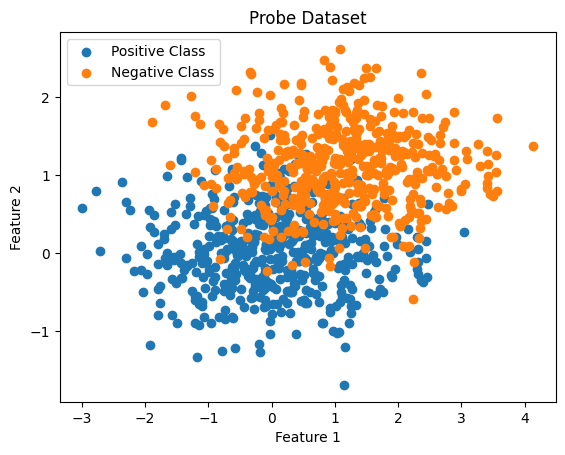

Logistic Regression Accuracy: 88.20%


In [43]:
from matplotlib import pyplot as plt
import numpy as np
reload(probes)


probe_dataset, probe_labels = probes.set_up_probe_dataset(model, layer_ind = 0, pos_points=pos_points, neg_points=neg_points, device=device)
# plot probe_dataset

print(f"probe_dataset.shape - {probe_dataset.shape}")
pos_probe_pts_inds = np.where(probe_labels == 1)[0]
neg_probe_pts_inds = np.where(probe_labels == 0)[0]
plt.scatter(probe_dataset[pos_probe_pts_inds, 0].cpu(), probe_dataset[pos_probe_pts_inds, 1].cpu(), label='Positive Class')
plt.scatter(probe_dataset[neg_probe_pts_inds, 0].cpu(), probe_dataset[neg_probe_pts_inds, 1].cpu(), label='Negative Class')
plt.legend()
plt.title('Probe Dataset')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()
# train logistic regression on probe_dataset
from sklearn.linear_model import LogisticRegression

probe_dataset = probe_dataset.cpu().numpy()
probe_labels = probe_labels.cpu().numpy()
# train logistic regression on probe_dataset
log_reg = LogisticRegression()
log_reg.fit(probe_dataset, probe_labels)
# print acc
print(f"Logistic Regression Accuracy: {log_reg.score(probe_dataset, probe_labels) * 100:.2f}%")


In [46]:
# train logistic regression on probe_dataset with probes
reload(probes)
acc, model_ = probes.train_logistic_regression(probe_dataset, probe_labels)
print(acc)

probe_dataset shape: torch.Size([1000, 2])
Epoch [100/1000], Loss: 0.4222
Epoch [200/1000], Loss: 0.3483
Epoch [300/1000], Loss: 0.3183
Epoch [400/1000], Loss: 0.3027
Epoch [500/1000], Loss: 0.2934
Epoch [600/1000], Loss: 0.2874
Epoch [700/1000], Loss: 0.2833
Epoch [800/1000], Loss: 0.2804
Epoch [900/1000], Loss: 0.2783
Epoch [1000/1000], Loss: 0.2768
Accuracy: 88.50%
88.50000500679016


In [13]:
data[0]

tensor([0.1940, 0.5404], device='cuda:0')

Epoch [100/1000], Loss: 0.1807
Epoch [200/1000], Loss: 0.1054
Epoch [300/1000], Loss: 0.0742
Epoch [400/1000], Loss: 0.0572
Epoch [500/1000], Loss: 0.0467
Epoch [600/1000], Loss: 0.0395
Epoch [700/1000], Loss: 0.0343
Epoch [800/1000], Loss: 0.0303
Epoch [900/1000], Loss: 0.0272
Epoch [1000/1000], Loss: 0.0246
Weights: [0.60254776 3.1632836 ], Bias: -3.764364004135132


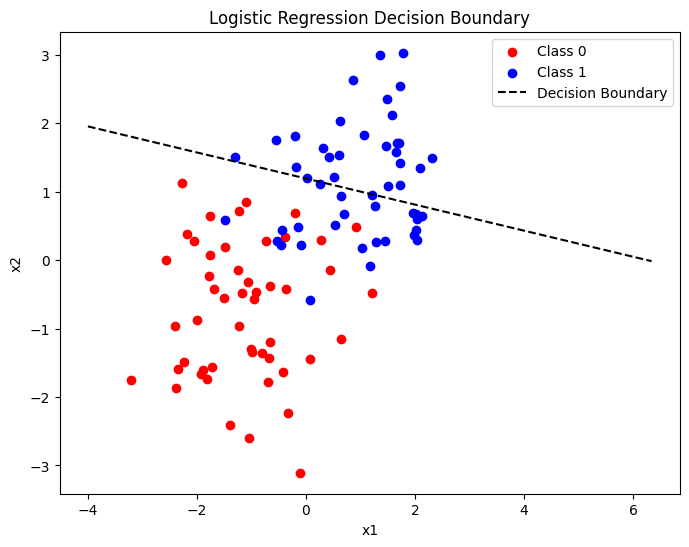

In [43]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Set random seed for reproducibility
torch.manual_seed(42)

# Generate synthetic dataset
N = 100  # total number of samples
D = 2    # number of features

# Data for class 0 and class 1
x0 = torch.randn(N // 2, D) - 1  # Class 0
x1 = torch.randn(N // 2, D) + 1  # Class 1
X = torch.cat([x0, x1], dim=0)
y = torch.cat([torch.zeros(N // 2), torch.ones(N // 2)], dim=0)

X = data.cpu()
y = labels.cpu()
# Define logistic regression model
class LogisticRegression(nn.Module):
    def __init__(self, input_dim):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(input_dim, 1)
        
    def forward(self, x):
        return torch.sigmoid(self.linear(x))

model = LogisticRegression(D)

# Loss and optimizer
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

# Training loop
num_epochs = 1000
for epoch in range(num_epochs):
    outputs = model(X).squeeze()
    loss = criterion(outputs, y)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

# Extract the weights and bias from the trained model
with torch.no_grad():
    w = model.linear.weight[0]  # weights for the two features
    b = model.linear.bias.item()  # bias

# Detach the weight tensor before converting it to a numpy array
print(f"Weights: {w.detach().numpy()}, Bias: {b}")
# Compute decision boundary: w1*x1 + w2*x2 + b = 0 --> x2 = -(w1/w2)*x1 - (b/w2)
# We generate x1 values across a range covering our dataset.
x1_vals = torch.linspace(X[:, 0].min()-1, X[:, 0].max()+1, 100)
if w[1] != 0:
    w = w.detach()
    
    x2_vals = -(w[0]/w[1]) * x1_vals - (b/w[1])
else:
    # In case w[1] is zero, plot a vertical line at -b/w[0]
    x1_boundary = -b/w[0]
    x1_vals = torch.full((100,), x1_boundary)
    x2_vals = torch.linspace(X[:, 1].min()-1, X[:, 1].max()+1, 100)

# Plotting the data and the decision boundary
plt.figure(figsize=(8,6))
# Plot class 0 points
plt.scatter(x0[:, 0].numpy(), x0[:, 1].numpy(), color='red', label='Class 0')
# Plot class 1 points
plt.scatter(x1[:, 0].numpy(), x1[:, 1].numpy(), color='blue', label='Class 1')
# Plot decision boundary
plt.plot(x1_vals.detach().numpy(), x2_vals.detach().numpy(), 'k--', label='Decision Boundary')

plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Logistic Regression Decision Boundary')
plt.legend()
plt.show()
